# Implementing a fully convolutional net

In [1]:
import logging
import numpy as np
import matplotlib.pyplot as plt
from fcn8s import FCN8s
import torch
from torch.utils.data import DataLoader

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2
logging.basicConfig(level=logging.INFO)

classes = ['background', 'coal', 'gangue']
colors = torch.Tensor([[0, 0, 0],  # background
                   [128, 0, 0], # coal
                   [0, 128, 0]] # gangue
                  ).long()
class_colors = ["aqua", "darkorange", "cornflowerblue"]
net = FCN8s(len(classes))


## Load data.

dataset size: 236


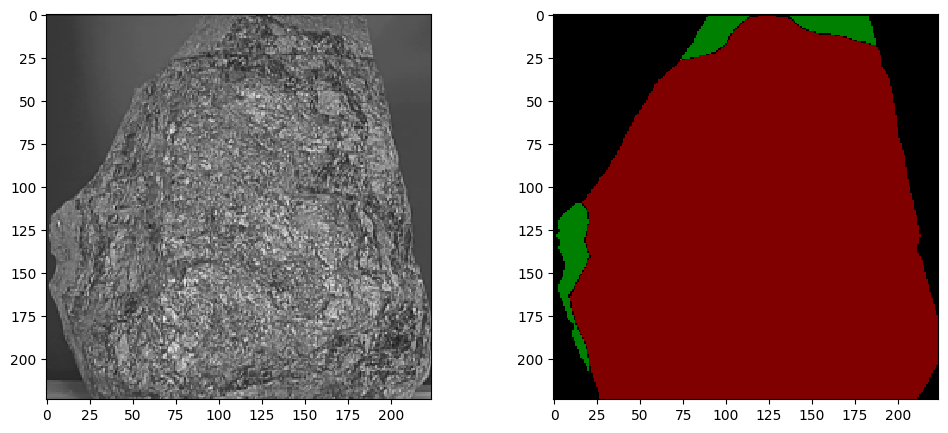

Training data shape:  torch.Size([4, 3, 224, 224])
Training labels shape:  torch.Size([4, 3, 224, 224])


In [2]:
import os
from one_hot import OneHotEncoder
from torch.utils.data import Subset
import torchvision.transforms as T
from trainer import Trainer
from coals import CoalsDataset
from config import Config

proj_dir = Config.get_project_dir()
final_dir = os.path.join(proj_dir, 'datasets/final')

transform = T.Compose([
            T.Resize(224),
            T.CenterCrop(224)
        ])

dataset  = CoalsDataset(final_dir, colors, classes, transform)
data_len = len(dataset)
print(f'dataset size: {data_len}')

indices = list(range(data_len))
split1 = int(data_len * 0.6)
split2 = int(data_len * 0.8)
train_indices, val_indices, test_indices = indices[:split1], indices[split1:split2], indices[split2:]
train_data = Subset(dataset, train_indices)
val_data = Subset(dataset, val_indices)
test_data = Subset(dataset, test_indices)

BATCH_SIZE = 4
NUM_WORKERS = 0
train_loader = DataLoader(
    train_data,
    BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)
val_loader = DataLoader(
    val_data,
    BATCH_SIZE,
    shuffle=False,
    drop_last=True,
    num_workers=NUM_WORKERS,
    pin_memory=False,
)
test_loader = DataLoader(
    test_data,
    BATCH_SIZE,
    shuffle=False,
    drop_last=True,
    num_workers=NUM_WORKERS,
    pin_memory=False,
)
img, mask = train_data[0]
mask_image = OneHotEncoder.decode(mask, colors)
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(img.permute(1, 2, 0))
plt.subplot(122)
plt.imshow(mask_image.permute(1, 2, 0))
plt.show()

X_train, y_train = next(iter(train_loader))
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)

trainer = Trainer(net, train_loader, val_loader, test_loader, classes, colors)

## Train a network

In [7]:
def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))
force_cudnn_initialization()

In [3]:
trainer.load_model()
trainer.train(epochs=50, learning_rate=1e-3, momentum=0.75, step_size=5, gamma=0.5)


model fcn8s loaded!


## Test

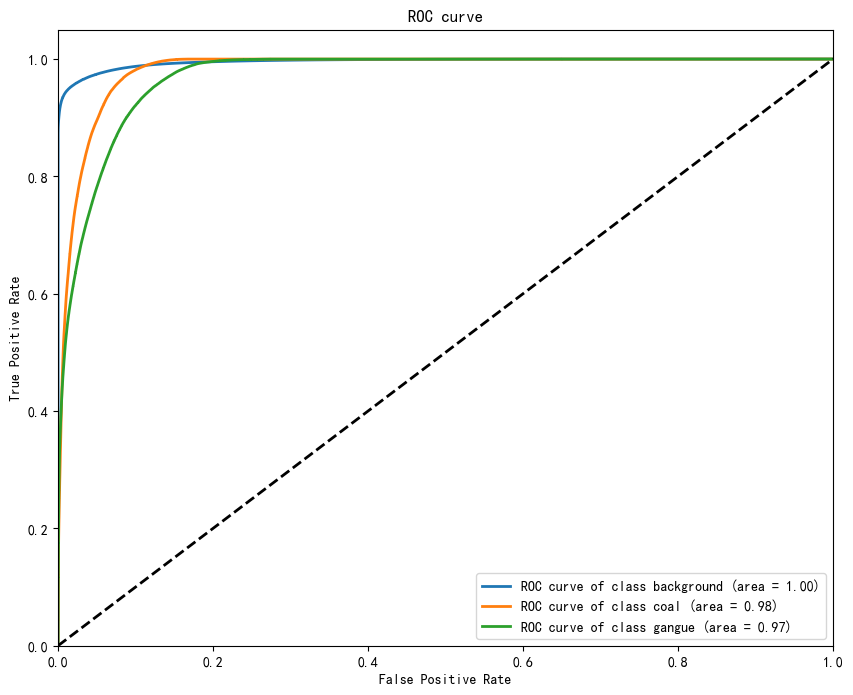

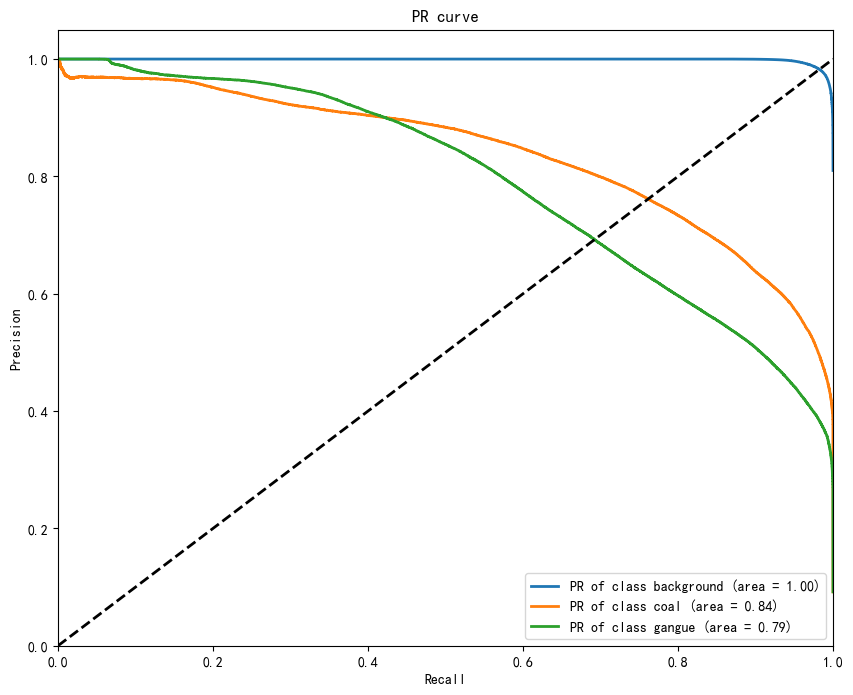

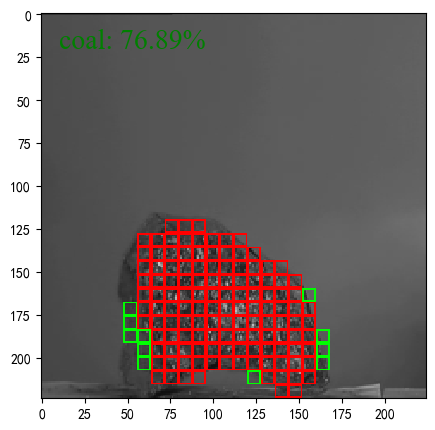

In [4]:
choice = 0
img, mask = test_data[choice]
pred = trainer.test()
pred = pred[choice,:,:,:]

pred_total = np.sum(pred.flatten(1,2).cpu().numpy(), axis=1)
proportion = pred_total[1] / (pred_total[1] + pred_total[2])


overlay_classes = [1, 2]
overlay_colors = colors = torch.Tensor([
                   [255, 0, 0], # coal
                   [0, 255, 0]] # gangue
                  ).long()
label = f"coal: {proportion * 100:.2f}%"
trainer.visualizer.draw_overlay_grid(img, overlay_classes, overlay_colors, pred, label)